 # Organic Partitioning & Coagulation Simulation

 This notebook demonstrates how to form secondary organic aerosol (SOA)
 from a mixture of gas-phase organics and to follow its evolution by
 Brownian coagulation.

 We will use a moving bin representation of particles, with vapor-liquid partitioning of organic vapours.

 **Road-map**
 1. Define physicochemical inputs
 2. Build gas species and the atmosphere
 3. Create seed particles and a particle representation
 4. Assemble an `Aerosol` object
 5. Run isothermal condensation (20 s)
 6. Add Brownian coagulation and continue for 10 min
 7. Visualise & discuss results
 

 > **Concept – Secondary Organic Aerosol (SOA):** particles that originate when low-volatility organic vapours condense onto pre-existing seeds.
 
 > **Concept – Partitioning:** the reversible transfer of a compound between the gas phase and the particle phase until thermodynamic equilibrium is reached.
 
 > **Concept – Brownian Coagulation:** random collisions driven by thermal motion that merge individual particles into larger ones, reducing number concentration while conserving mass.

<details> <summary>▶️ Install Particula</summary>
try:
    import google.colab
except ImportError:
    # not Colab → do nothing
    pass
else:
    # in Colab → install quietly
    get_ipython().system("pip install particula[extra] --quiet")
</details>

In [17]:

import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import particula as par

# move to particle properties and update to API style.
from particula.activity.species_density import organic_array

# plot settings
TAILWIND = par.util.colors.TAILWIND
base_color = TAILWIND["gray"]["600"]
plt.rcParams.update(
    {
        "text.color": base_color,
        "axes.labelcolor": base_color,
        "figure.figsize": (5, 4),
        "font.size": 14,
        "axes.edgecolor": base_color,
        "axes.labelcolor": base_color,
        "xtick.color": base_color,
        "ytick.color": base_color,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)

 ## Physicochemical inputs
 
 Molecular weight, O:C & H:C ratios, saturation concentrations and
 total gas-phase concentrations gathered from the literature.
 
 >
 > **O:C ratio (oxygen-to-carbon):** proxy for oxidation state – a
 > higher ratio usually implies higher polarity and lower volatility.
 >
 > **c_sat:** saturation concentration (often noted *C\**); at this
 > concentration the compound is in equilibrium between gas and
 > particle phases.
 >
 > All concentrations are specified in µg m⁻³ to mimic experimental
 > data and are converted to SI units by the builders.

In [18]:
M_gmol = np.array(
    [200.0, 188.0, 216.0, 368.0, 186.0, 204.0, 195.0, 368.0, 158.0, 206.0]
)

OC_ratio = np.array(
    [0.40, 0.444, 0.50, 0.368, 0.444, 0.556, 0.857, 0.368, 0.375, 0.75]
)

HC_ratio = np.array(
    [1.60, 1.78, 1.60, 1.47, 1.56, 1.78, 1.75, 1.56, 1.75, 1.75]
)


density_organics_g_cm3 = organic_array(
    molar_mass=M_gmol,
    oxygen2carbon=OC_ratio,
    hydrogen2carbon=HC_ratio,
)  # g/cm^3

c_total_ug_per_m3 = (
    np.array([8.79, 3.98, 1.13, 4.07, 0.628, 0.919, 0.766, 1.02, 0.399, 0.313])
    * 10000
)

name = np.array(
    [
        "C107OOH",
        "C97OOH",
        "C108OOH",
        "ALDOL_dimer_C19H28O7",
        "PINIC",
        "C921OOH",
        "C812OOH",
        "ESTER_dimer",
        "C811OH",
        "C813OOH",
    ]
)

c_sat_ug_per_m3 = np.array(
    [
        8620.171693,
        522.7659518,
        231.757194,
        2.27e-06,
        24.13243017,
        3.131375563,
        1.107025816,
        2.97e-06,
        2197.484083,
        0.04398829,
    ]
)

# sulfate properties
sulfate_density = 1.77 * 1000  # kg/m^3
sulfate_molar_mass = 96.06  # g/mol

temperature_K = 298.15

 ## Build gas-phase species
 Each species receives a vapour-pressure *strategy* so that the code
 can evaluate temperature-dependent properties on the fly.
 Note: the saturation-concentration builder is a convenient wrapper
 converting **μg m⁻³ → Pa**.
 
 
 > **Strategy pattern:** every species owns a *strategy* object that
 > knows how to compute its pure vapour pressure – we can switch
 > correlations without touching core logic.
 >
 > `SaturationConcentrationVaporPressureBuilder` back-calculates
 > vapour pressure from the published saturation concentration *C\**.

In [19]:
# vapor pressures
vapor_pressure_strategies = []
for i in range(len(name)):
    vapor_pressure_organic = (
        par.gas.SaturationConcentrationVaporPressureBuilder()
        .set_molar_mass(M_gmol[i], "g/mol")
        .set_temperature(temperature_K, "K")
        .set_saturation_concentration(c_sat_ug_per_m3[i], "ug/m^3")
        .build()
    )
    vapor_pressure_strategies.append(vapor_pressure_organic)

organics_gases = (
    par.gas.GasSpeciesBuilder()
    .set_name(name)
    .set_molar_mass(M_gmol, "g/mol")
    .set_vapor_pressure_strategy(vapor_pressure_strategies)
    .set_concentration(c_total_ug_per_m3, "ug/m^3")
    .set_partitioning(True)
    .build()
)

 ## Compose the atmosphere

 Combine temperature, pressure and the list of partitioning species
 into a single `Atmosphere` container.


 > **Atmosphere object:** central thermodynamic context (temperature &
 > pressure).  All processes query these values rather than carrying
 > their own copies.
 sulfate vapor pressure

In [20]:
sulfate_vapor_pressure = (
    par.gas.ConstantVaporPressureBuilder()
    .set_vapor_pressure(1e-30, "Pa")
    .build()
)
sulfate_gas = (
    par.gas.GasSpeciesBuilder()
    .set_name("Sulfate")
    .set_molar_mass(96.06, "g/mol")
    .set_vapor_pressure_strategy(sulfate_vapor_pressure)
    .set_concentration(0, "ug/m^3")
    .set_partitioning(True)
    .build()
)

# create atmosphere
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_temperature(temperature_K, "K")
    .set_pressure(1.0, "atm")
    .set_more_partitioning_species(sulfate_gas)
    .set_more_partitioning_species(organics_gases)
    .build()
)

## Seed particles

 Generate a log-normal size distribution of sulfate seeds and assign
 species-resolved mass bins.
 Tip: for speed you may reduce the radius grid – 250 points is rather
 fine for demonstration purposes.

 > **Log-normal distribution:** widely observed for atmospheric
 > aerosols; characterised by a modal radius and geometric standard
 > deviation (GSD).
 >
 > We convert the number distribution to a probability-mass function
 > (PMF) so the integral equals the desired particle count.

In [ ]:
total_number_concentration = np.array([1e13])  # /m-3
particle_radius = np.logspace(-7.5, -6.3, 250)  # m

# create sulfate seeds
number_concentration = par.particles.get_lognormal_pmf_distribution(
    x_values=particle_radius,
    mode=np.array([100e-9]),
    geometric_standard_deviation=np.array([1.4]),
    number_of_particles=total_number_concentration,
)

# calculate mass in each bin
sulfate_volume_distribution = 4.0 / 3.0 * np.pi * particle_radius**3
sulfate_mass_distribution = sulfate_volume_distribution * sulfate_density

organic_mass_distribution = np.zeros(
    (len(sulfate_mass_distribution), len(M_gmol)), dtype=float
) 

mass_distribution = np.concatenate(
    (sulfate_mass_distribution[:, np.newaxis], organic_mass_distribution),
    axis=1,
)

particle_molar_mass = np.append(sulfate_molar_mass, M_gmol)
particle_densities = np.append(
    sulfate_density, density_organics_g_cm3 * 1000
)  # kg/m^3
activity_strategies = (
    par.particles.ActivityIdealMolarBuilder()
    .set_molar_mass(particle_molar_mass, "g/mol")
    .build()
)

# the surface tension and activity may have a bug in it causing it to be more evaporative
# than it should be, so we set it to a very low value, and are investigating it.
surface_tension = np.append(0.09, np.ones(len(M_gmol)) * 0.0003)  # N/m
surface_strategy = (
    par.particles.SurfaceStrategyVolumeBuilder()
    .set_surface_tension(surface_tension, "N/m")
    .set_density(particle_densities, "kg/m^3")
    .set_phase_index(np.append(0, np.ones(len(M_gmol))))
    .build()
)

## Particle representation

 Attach activity, surface and distribution strategies.  Using
 `SpeciatedMassMovingBin` lets the bin boundaries adapt when mass is
 added.

**SpeciatedMassMovingBin:** bin boundaries adapt when mass is added
– avoids artificial dilution present in fixed-grid schemes.

**Activity & surface strategies:** thermodynamics (ideal,
etc.) and surface tension models are swappable components, keeping
the main algorithm clean.

In [22]:
particle_representation = (
    par.particles.ParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.SpeciatedMassMovingBin())
    .set_activity_strategy(activity_strategies)
    .set_mass(mass_distribution, "kg")
    .set_concentration(number_concentration, "1/m^3")
    .set_charge(0)
    .set_density(particle_densities, "kg/m^3")
    .set_surface_strategy(surface_strategy)
    .build()
)


## Assemble aerosol

 Wrap atmosphere + particles into a single high-level object that the
 dynamical processes will modify in place.

**Big picture:** `Aerosol` = `Atmosphere` + `ParticleRepresentation`.
Every subsequent *Runnable* process expects a single aerosol object
and modifies it in place.

In [23]:
# Build aerosol
aerosol = (
    par.AerosolBuilder()
    .set_atmosphere(atmosphere)
    .set_particles(particle_representation)
    .build()
)

print(aerosol)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['Sulfate' 'C107OOH' 'C97OOH' 'C108OOH' 'ALDOL_dimer_C19H28O7' 'PINIC'
 'C921OOH' 'C812OOH' 'ESTER_dimer' 'C811OH' 'C813OOH'], gas_only_species=None
Particle Representation:
	Strategy: SpeciatedMassMovingBin
	Activity: ActivityIdealMolar
	Surface: SurfaceStrategyVolume
	Mass Concentration: 1.234e-04 [kg/m^3]
	Number Concentration: 1.000e+13 [#/m^3]


 ## Condensation process

 We use an isothermal Fuchs–Sutugin formulation.
 `skip_partitioning_indices=[0]` excludes sulfate from condensation.

 > **Performance hint** – the number of sub-steps controls accuracy.
 >
 > `update_gases=True` removes vapours from the gas pool as they
 > condense, enforcing mass conservation.
 >
 > The `RunnableSequence` uses the `|` pipe operator for a fluent
 > interface

In [24]:
# Condensation Coagulation process setup
condensation_strategy = par.dynamics.CondensationIsothermal(
    molar_mass=particle_molar_mass,
    diffusion_coefficient=2e-5,
    accommodation_coefficient=1,
    update_gases=True,
    skip_partitioning_indices=[0],  # no partitioning for sulfate
)
condensation_process = par.dynamics.MassCondensation(condensation_strategy)

sequence_condensation = par.RunnableSequence() | condensation_process

# Copy aerosol and define time bins
aerosol_initial = copy.deepcopy(aerosol)
aerosol_soa = copy.deepcopy(aerosol)

 ### Single 20 s condensation pulse
 
 Useful for inspecting how much SOA forms before coagulation starts.
 
 > We pick a very small internal sub-step
 > (`Δt_sub = 20 s / 100 000 ≈ 2×10⁻⁴ s`) to capture the rapid initial
 > uptake of vapours onto nano-particles.
 10 sec simulation

Executing Runnable: 100%|██████████| 100000/100000 [03:08<00:00, 530.42it/s]


Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['Sulfate' 'C107OOH' 'C97OOH' 'C108OOH' 'ALDOL_dimer_C19H28O7' 'PINIC'
 'C921OOH' 'C812OOH' 'ESTER_dimer' 'C811OH' 'C813OOH'], gas_only_species=None
Particle Representation:
	Strategy: SpeciatedMassMovingBin
	Activity: ActivityIdealMolar
	Surface: SurfaceStrategyVolume
	Mass Concentration: 2.749e-04 [kg/m^3]
	Number Concentration: 1.000e+13 [#/m^3]


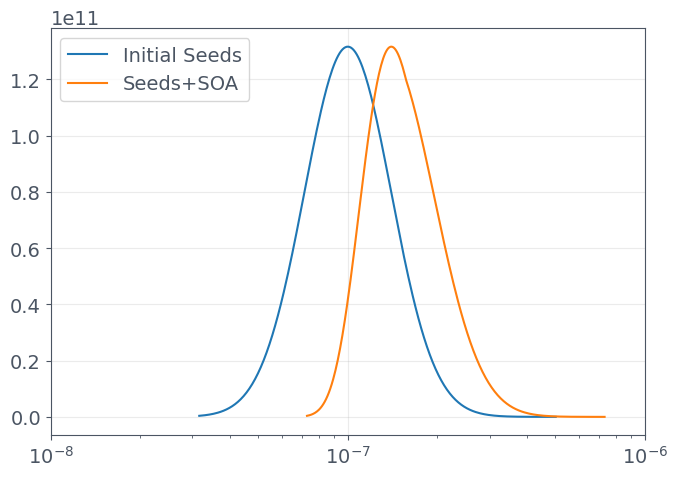

In [25]:
aerosol_soa = sequence_condensation.execute(
    aerosol=aerosol_soa,
    time_step=20,
    sub_steps=100_000,
)

print(aerosol_soa)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(
    aerosol_initial.particles.get_radius(),
    aerosol_initial.particles.get_concentration(),
    label="Initial Seeds",
)
ax.plot(
    aerosol_soa.particles.get_radius(),
    aerosol_soa.particles.get_concentration(),
    label="Seeds+SOA",
)
ax.legend(loc="upper left")
ax.set_xscale("log")
ax.set_xlim(left=1e-8, right=1e-6)
ax.grid(alpha=0.25)
fig.tight_layout()

 ## Coagulation process

 Builder selects a discrete Brownian kernel.  Other kernels are
 available and can be swapped by changing the builder called.

 > **Brownian kernel:** collision frequency determined solely by random
 > thermal motion; other kernels 
 > can be swapped by changing a single builder call.

In [26]:
# coagulation process setup
coagulation_strategy = (
    par.dynamics.BrownianCoagulationBuilder()
    .set_distribution_type("discrete")
    .build()
)
coagulation_process = par.dynamics.Coagulation(coagulation_strategy)

 ## Combined simulation (10 min)

 We alternate long, finely-resolved condensation steps with coarse
 coagulation steps.
 Rule of thumb: `time_step / sub_steps ≈ 0.01 s` keeps condensation
 stable while minimising overhead.

Experiment: toggle condensation on to see if coagulation+condensation changes the particle size distribution.
 
 
 > We loop over 60 outer steps of 10 s each to reach 10 min.  Inside
 > every step we *could* run condensation with many sub-steps while
 > keeping coagulation coarse – a trade-off between accuracy and
 > speed.
.

In [27]:
# %% staggered time stepping

aerosol_process = copy.deepcopy(aerosol_soa)

total_time = 600  # seconds
total_steps = 60

coagulation_sub_step = 1
condensation_sub_step = 50_000

time_step = total_time / total_steps

for step in tqdm(range(total_steps), desc="Running Sim", mininterval=0.5):

    # execute condensation process, this is the slowest computationally
    # feel free to comment this out to see the effect of coagulation only
    # aerosol_process = condensation_process.execute(
    #     aerosol=aerosol_process,
    #     time_step=time_step,
    #     sub_steps=condensation_sub_step,
    # )

    # execute coagulation process
    aerosol_process = coagulation_process.execute(
        aerosol=aerosol_process,
        time_step=time_step,
        sub_steps=coagulation_sub_step,
    )

Running Sim: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


 ## Results

 The figure contrasts (i) the initial seed distribution, (ii) mass
 growth after 20 s of SOA partitioning, and (iii) its further
 evolution through coagulation.


 > Observe how number concentration drops (coagulation) while the
 > median radius grows (condensation + coagulation).
 > Try commenting out condensation to isolate the effect of pure
 > coagulation broadening the distribution without adding mass.

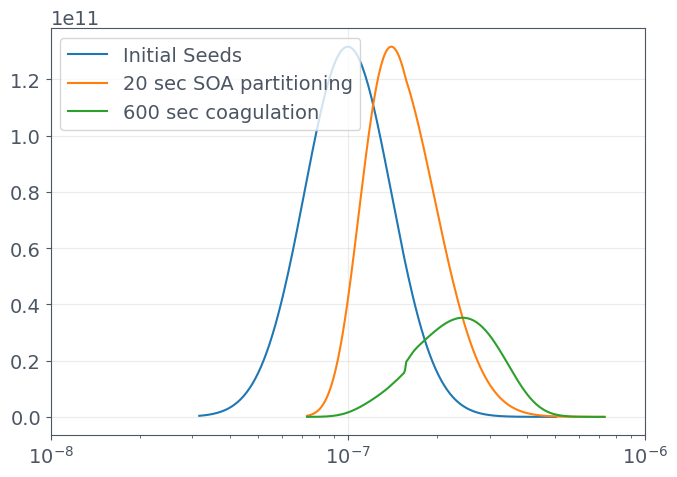

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(
    aerosol_initial.particles.get_radius(),
    aerosol_initial.particles.get_concentration(),
    label="Initial Seeds",
)
ax.plot(
    aerosol_soa.particles.get_radius(),
    aerosol_soa.particles.get_concentration(),
    label="20 sec SOA partitioning",
)
ax.plot(
    aerosol_process.particles.get_radius(),
    aerosol_process.particles.get_concentration(),
    label="600 sec coagulation",
    # marker=".",
)
ax.legend(loc="upper left")
ax.set_xscale("log")
ax.grid(alpha=0.25)
ax.set_xlim(left=1e-8, right=1e-6)
fig.tight_layout()

## Summary

This notebook demonstrates how to simulate the formation of secondary
organic aerosol (SOA) from gas-phase organics and its evolution by
Brownian coagulation.  We used a moving bin representation of particles
with vapour-liquid partitioning, allowing us to model the complex
interactions between gas-phase species and particle growth.
